In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load user data and transaction data
users = pd.read_csv("C:/Users/shahp/Downloads/datasets/datasets/users.csv")
transactions = pd.read_csv("C:/Users/shahp/Downloads/datasets/datasets/transactions.csv")

In [4]:
# Recreate df if not already defined
# Aggregate transaction-level features
tx_agg = transactions.groupby('USER_ID').agg(
    chip_usage_rate=('ENTRY_METHOD', lambda x: (x == 'chip').mean()),
    card_payment_rate=('TYPE', lambda x: (x == 'CARD_PAYMENT').mean())
).reset_index()

# Merge with fraud labels
df = users[['ID', 'IS_FRAUDSTER']].merge(tx_agg, left_on='ID', right_on='USER_ID', how='left')
df[['chip_usage_rate', 'card_payment_rate']] = df[['chip_usage_rate', 'card_payment_rate']].fillna(0)


Fraudster value counts:
IS_FRAUDSTER
False    9646
True      298
Name: count, dtype: int64

Fraud rate: 0.0300


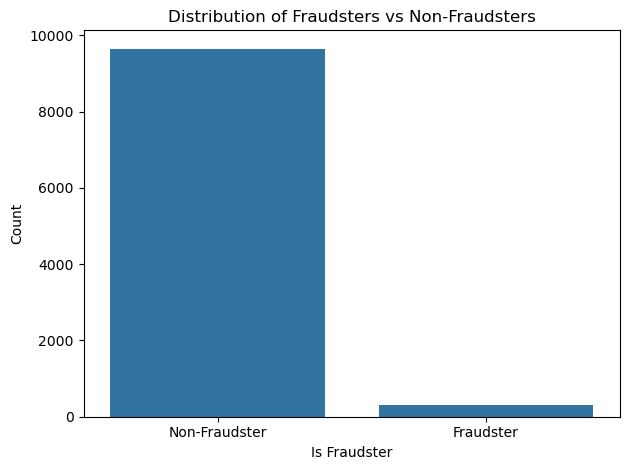

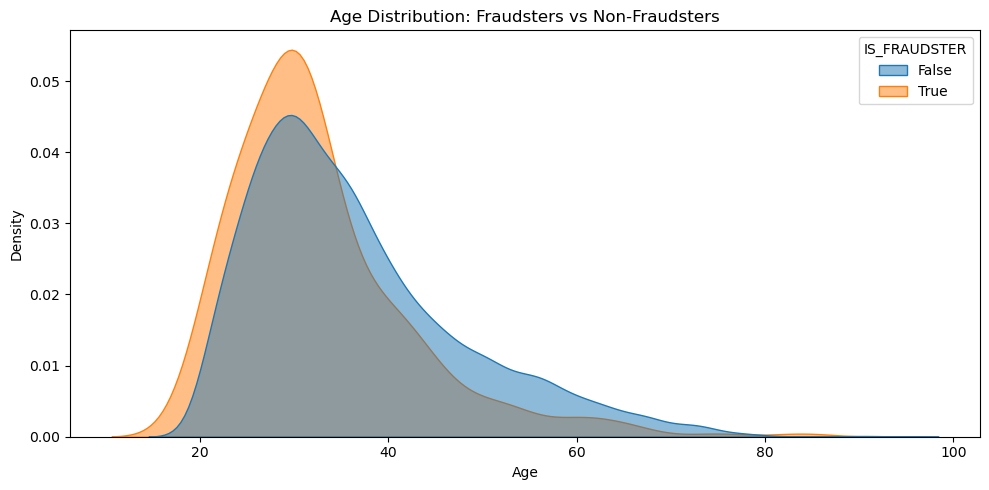

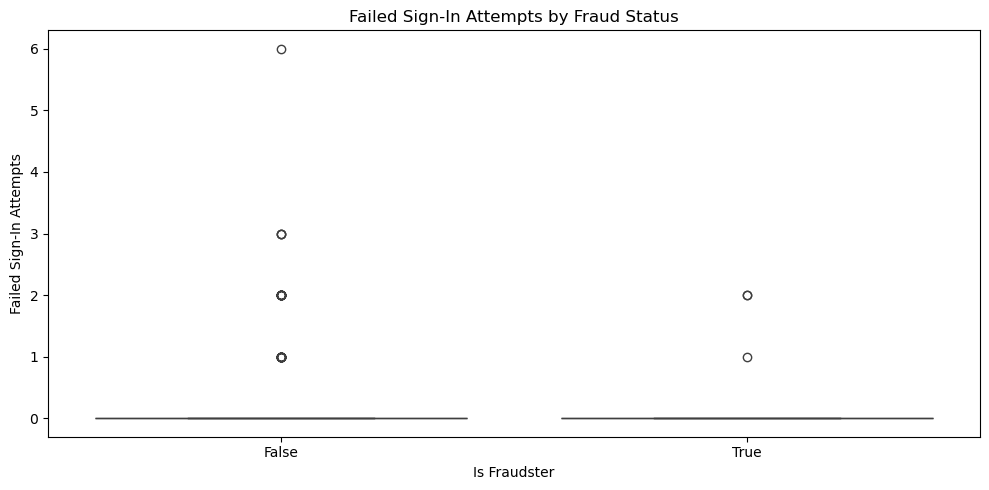

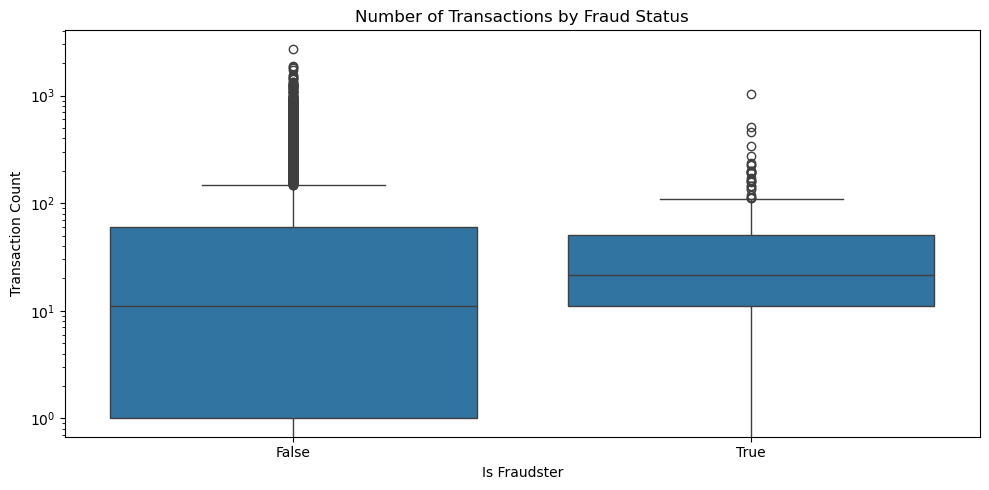

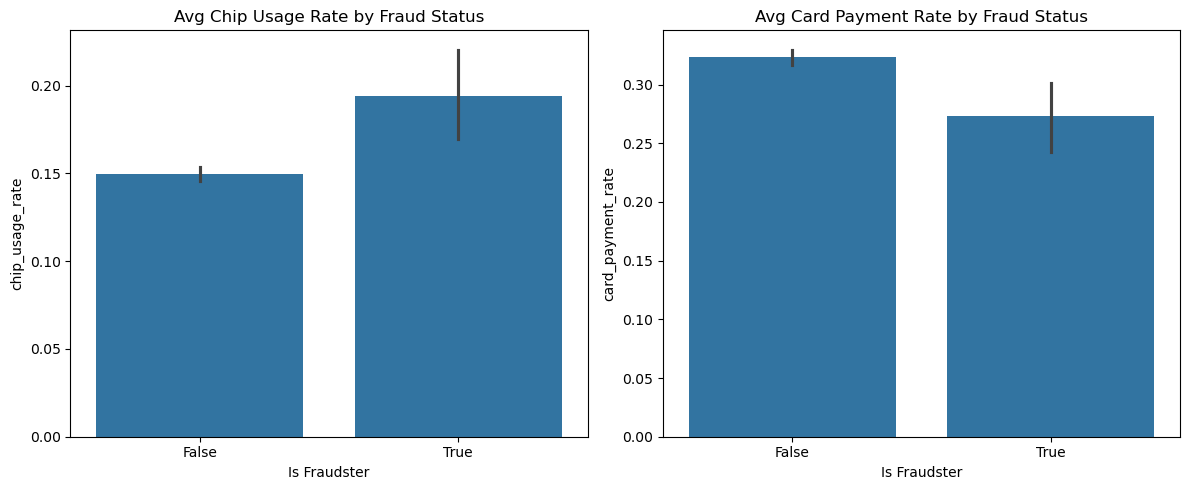

In [5]:
# ---------------------- EDA ----------------------

# Fraudster distribution
print("Fraudster value counts:")
print(users['IS_FRAUDSTER'].value_counts())

# Compute and print the percentage of fraud in dataset
fraud_rate = users['IS_FRAUDSTER'].mean()
print(f"\nFraud rate: {fraud_rate:.4f}")

# Fraud class distribution
# Plot class distribution
sns.countplot(x='IS_FRAUDSTER', data=users)
plt.title("Distribution of Fraudsters vs Non-Fraudsters")
plt.xlabel("Is Fraudster")
plt.ylabel("Count")
plt.xticks([0, 1], ['Non-Fraudster', 'Fraudster'])
plt.tight_layout()
plt.show()

# Age distribution by Fraud status
# Create AGE feature first if not done
users['AGE'] = 2020 - users['BIRTH_YEAR']

# Plot KDE for age distribution
plt.figure(figsize=(10,5))
sns.kdeplot(data=users, x='AGE', hue='IS_FRAUDSTER', fill=True, common_norm=False, alpha=0.5)
plt.title("Age Distribution: Fraudsters vs Non-Fraudsters")
plt.xlabel("Age")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Failed sign-in attempts
plt.figure(figsize=(10,5))
sns.boxplot(x='IS_FRAUDSTER', y='FAILED_SIGN_IN_ATTEMPTS', data=users)
plt.title("Failed Sign-In Attempts by Fraud Status")
plt.xlabel("Is Fraudster")
plt.ylabel("Failed Sign-In Attempts")
plt.tight_layout()
plt.show()


# Transaction count vs fraud
# Merge transaction counts for EDA
tx_counts = transactions.groupby('USER_ID')['ID'].count().reset_index(name='tx_count')
users_tx = users.merge(tx_counts, left_on='ID', right_on='USER_ID', how='left').fillna(0)

plt.figure(figsize=(10,5))
sns.boxplot(x='IS_FRAUDSTER', y='tx_count', data=users_tx)
plt.title("Number of Transactions by Fraud Status")
plt.xlabel("Is Fraudster")
plt.ylabel("Transaction Count")
plt.yscale('log')  # In case of extreme outliers
plt.tight_layout()
plt.show()

# Chip usage and card payment rate by fraud
# Barplots to show means
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='IS_FRAUDSTER', y='chip_usage_rate', data=df, ax=axs[0])
axs[0].set_title("Avg Chip Usage Rate by Fraud Status")
axs[0].set_xlabel("Is Fraudster")

sns.barplot(x='IS_FRAUDSTER', y='card_payment_rate', data=df, ax=axs[1])
axs[1].set_title("Avg Card Payment Rate by Fraud Status")
axs[1].set_xlabel("Is Fraudster")

plt.tight_layout()
plt.show()



In [6]:
# ------------------ FEATURE ENGINEERING ------------------

# Create AGE feature from BIRTH_YEAR
users['AGE'] = 2020 - users['BIRTH_YEAR']

# Encode KYC status
users['KYC'] = users['KYC'].map({'PASSED': 1, 'FAILED': 0})

# Aggregate transaction features
tx_agg = transactions.groupby('USER_ID').agg(
    tx_count=('ID', 'count'),
    tx_avg_amt=('AMOUNT_USD', 'mean'),
    tx_max_amt=('AMOUNT_USD', 'max'),
    tx_std_amt=('AMOUNT_USD', 'std'),
    tx_type_nunique=('TYPE', 'nunique'),
    tx_country_nunique=('MERCHANT_COUNTRY', pd.Series.nunique),
    chip_usage_rate=('ENTRY_METHOD', lambda x: (x == 'chip').mean()),
    card_payment_rate=('TYPE', lambda x: (x == 'CARD_PAYMENT').mean())
).reset_index()

# Replace NaNs from std with 0 (no variation if only 1 tx)
tx_agg = tx_agg.fillna(0)

# Merge
df = users.merge(tx_agg, left_on='ID', right_on='USER_ID', how='left').drop(columns=['USER_ID'])

# Fill missing tx features for users with no transactions
tx_cols = ['tx_count', 'tx_avg_amt', 'tx_max_amt', 'tx_std_amt', 'tx_type_nunique', 'tx_country_nunique', 'chip_usage_rate', 'card_payment_rate']
df[tx_cols] = df[tx_cols].fillna(0)

# Encode country/state if needed
df['COUNTRY_CODE'] = LabelEncoder().fit_transform(df['COUNTRY'])
df['STATE_CODE'] = LabelEncoder().fit_transform(df['STATE'])

In [7]:
# ------------------ MODEL TRAINING ------------------

# Define the final set of features for modeling
feature_cols = ['HAS_EMAIL', 'AGE', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS',
                'tx_count', 'tx_avg_amt', 'tx_max_amt', 'tx_std_amt',
                'tx_type_nunique', 'tx_country_nunique',
                'chip_usage_rate', 'card_payment_rate']

X = df[feature_cols] #feature matrix
y = df['IS_FRAUDSTER'] # Target variable

# Split data into training and test sets (stratified by class)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train a Random Forest with class weighting for imbalance
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict labels and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      2895
        True       0.78      0.20      0.32        89

    accuracy                           0.97      2984
   macro avg       0.88      0.60      0.65      2984
weighted avg       0.97      0.97      0.97      2984


Confusion Matrix:
[[2890    5]
 [  71   18]]

ROC-AUC Score: 0.9036


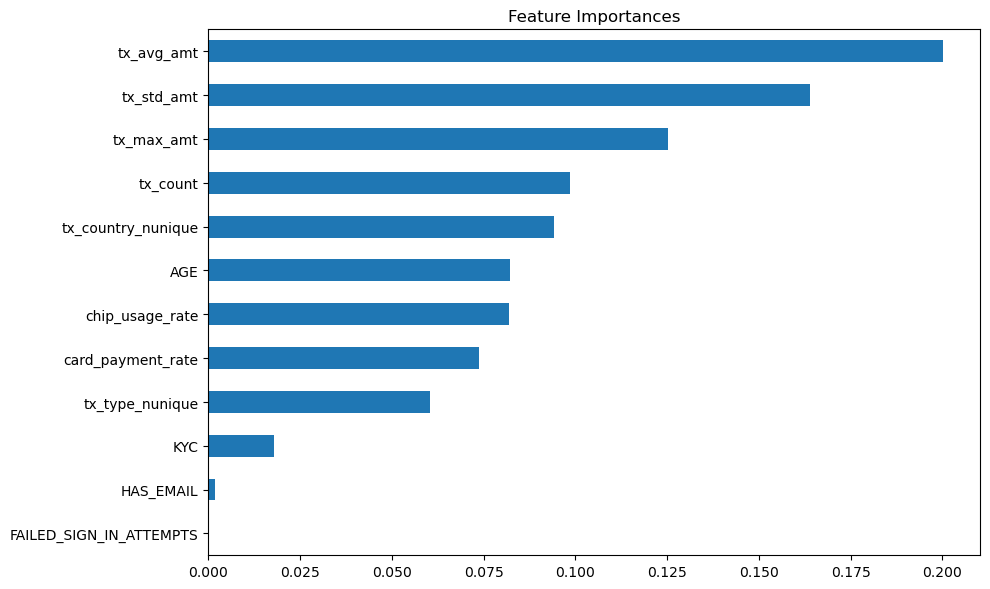

In [8]:
# ------------------ EVALUATION ------------------

# Print classification performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print ROC-AUC score for model
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Plot feature importances
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances.sort_values().plot(kind='barh', figsize=(10,6), title="Feature Importances")
plt.tight_layout()
plt.show()

## Key Insights from Exploratory Data Analysis (EDA)

### 1. Class Imbalance
- The dataset is highly imbalanced, with fraudsters comprising a very small fraction of users.
- This confirms the need for techniques like `class_weight='balanced'` and evaluation metrics like **ROC-AUC** or **F1-score** rather than accuracy.

### 2. Age Distribution
- Fraudsters appear to skew slightly younger, with more users in the 20–35 age range.
- Non-fraudulent users show a more evenly distributed age profile.

### 3. Failed Sign-In Attempts
- Fraudulent users exhibit **higher numbers of failed login attempts**, possibly indicating brute-force attacks or account probing activity.

### 4. Transaction Volume
- Fraudsters tend to have **fewer transactions** overall compared to legitimate users.
- This suggests opportunistic behavior—such as committing fraud in a few transactions and abandoning the account afterward.

### 5. Chip Usage Rate
- Fraudsters have a **lower rate of chip-based transactions**, which are considered more secure.
- They may prefer manual entry or less secure alternatives, hinting at potential card-present fraud or skimming.

### 6. Card Payment Rate
- Fraudsters show a **slightly higher reliance on card payments**.
- This may reflect usage of stolen card credentials or attempts to rapidly extract value from compromised accounts.

## Implications for Feature Engineering
- Fraudulent behavior is **subtle and behavioral**, not always extreme.
- Key predictive features are not just transaction volume but also **how** transactions are made (e.g., entry method).
- Combining static attributes (e.g., age, KYC) with dynamic behavior (e.g., chip usage, failed sign-ins) enhances model effectiveness.